구현해야 할 것
- HeatmapParser
- flipped ensemble evaluation
- Dataset analysis
- (v) mpii_eval 
- (v) generator for mpii_eval(img, gts)

In [1]:
from data.dp import Dataset

import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from eval import HumanPoseEstimator
from eval import show_hms

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [2]:
INPUT_RES = 256
OUTPUT_RES = 64
NUM_PARTS = 16
EPOCH = 3

HPE = HumanPoseEstimator(INPUT_RES, OUTPUT_RES, NUM_PARTS, EPOCH)

Model: "HPE"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 64) 9472        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 128, 64) 256         conv2d[0][0]                     
__________________________________________________________________________________________________
tf.nn.relu (TFOpLambda)         (None, 128, 128, 64) 0           batch_normalization[0][0]        
________________________________________________________________________________________________

In [3]:
test_dir = 'data/test'
test_list = os.listdir(test_dir)
test_list.remove('result')
for test in test_list:
    src = os.path.join(test_dir, test)
    dst = os.path.join(test_dir, 'result', test)
    img, hms, joints = HPE.inference(src, dst)

Saved "data/test/result/test002.jpg"
Saved "data/test/result/test004.jpg"
Saved "data/test/result/test003.jpg"
Saved "data/test/result/test005.png"
Saved "data/test/result/test001.png"


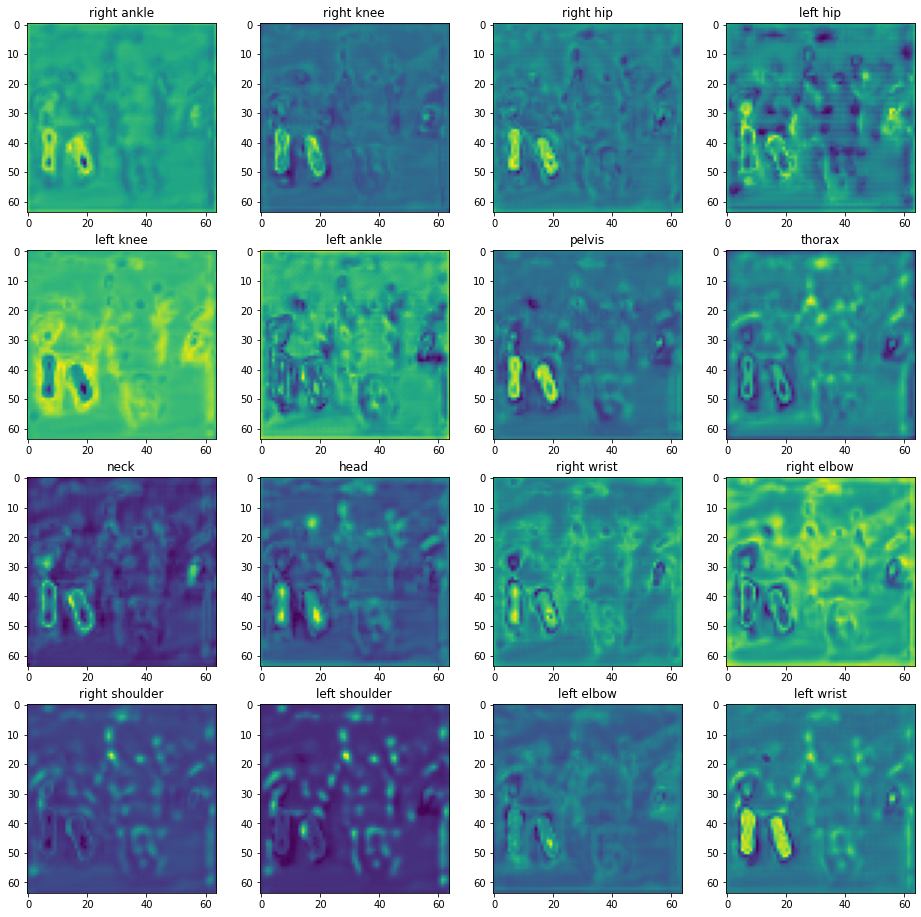

In [4]:
show_hms(hms)

In [10]:
HPE.eval_PCK()

loading data: valid.h5
Done (t=0.44s)
  1%|▏         | 41/2958 [00:02<03:08, 15.47it/s]


KeyboardInterrupt: 

In [38]:
print(len(joints))

64


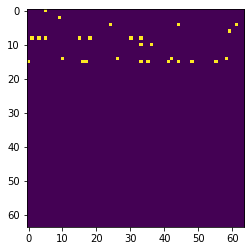

In [24]:
jointmap = np.zeros((64*64), dtype=np.float32)
joint = []
for i in range(hms.shape[2]):
    idx = np.argmax(hms[:,:,i])
    jointmap[idx] = 1
    joint.append((idx % 64, idx // 64))
jointmap = jointmap.reshape((64, 64))
plt.imshow(jointmap)

In [8]:
joints = np.array(joints)/64*256

In [9]:
pairs = [[0, 1], [1, 2], [2, 6], [6, 3], [3, 4], [4, 5], [6, 7], [7, 8], [8, 9], [10, 11], [11, 12], [12, 7], [15, 14], [14, 13], [13, 7]]

In [10]:
bone = []
for pair in pairs:
    b = []
    for p in pair:
        b.append(joints[p])
    bone.append(b)

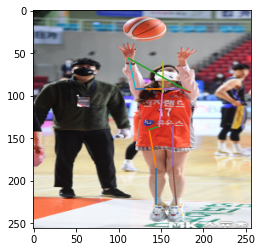

In [11]:
bone = np.array(bone)
plt.imshow(img[0])

for b in bone:
    x = []
    y = []
    for _x, _y in b:
        x.append(_x)
        y.append(_y)
    plt.plot(x, y)